<a href="https://colab.research.google.com/github/relfarizi/Portfolio-Saham/blob/master/Portfolio_Saham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portofolio Saham
Buat portofolio minimal terdiri dari 5 buah saham. Portofolio dibangun berdasarjan data historis saham mingguan (weekly). Minimal data yang digunakan adalah 2 tahun (2017 sampai 2018)

## Load Data

### Data Saham

In [0]:
import pandas as pd
import regex as re
"""
kode_saham = ["AAPL","BA","BATA.JK","BKRKF","CSCO","IBM",
              "TLKMF","AKPI.JK","INTC","MSFT","NVDA",
              "ORCL","PBCRF","PHJMF","PTAIF","SPR"]
"""

#fix 
"""
kode_saham = ["BKRKF",
              "TLKMF",
              "PHJMF"]

"""
# variansi besar
#kode_saham = ["AAPL","BA","BATA.JK","AKPI.JK","INTC","MSFT","NVDA","ORCL","CSCO","IBM","SPR"]

#kode_saham = ["BATA.JK","AKPI.JK"]

kode_saham =["SGRO.JK","TLKM.JK","INDR.JK","PRDA.JK","AKPI.JK"]
#kode_saham =["SGRO.JK","PHJMF"]
def load_data(tahun,kode_saham = kode_saham) :
  kode_tmp = []
  sama = False
  for i in kode_saham :
    if i in kode_tmp :
      sama =  True
      kodenya = i
      break
    else :
        kode_tmp.append(i)

  if sama :
    dataset = []
    print("ada yang sama", kodenya)
  else :
    n = len(kode_saham)
    github = "https://raw.githubusercontent.com/relfarizi/Portfolio-Saham/master/Data/"+str(tahun)+"/"

    df = []
    for i in range(n) :
      datas = pd.read_csv(github+kode_saham[i]+".csv")

      if re.findall("adsad",kode_saham[i]):
        tmp = datas["Close"].tolist()
        data_tmp = convert_to_dollar(tmp)
      else :
        data_tmp =datas["Close"]
      df.append(pd.DataFrame(data_tmp))
      #print(data_tmp.shape)
    dataset = pd.concat(df, axis=1, sort=False)
    dataset = dataset.dropna()
    dataset.columns = kode_saham
  return dataset

dataset = load_data("2017-2018")

### Korelasi Saham

In [205]:
rho = dataset.corr().values
dataset.corr()

,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK
SGRO.JK,1.000000,-0.336531,0.282667,-0.599204,-0.559313
TLKM.JK,-0.336531,1.000000,-0.647548,0.348964,0.244041
INDR.JK,0.282667,-0.647548,1.000000,-0.715454,-0.019710
PRDA.JK,-0.599204,0.348964,-0.715454,1.000000,0.189698
AKPI.JK,-0.559313,0.244041,-0.019710,0.189698,1.000000


In [0]:
def find_k(saham) :
  K = []
  for i in range(len(saham)-1) :
    x = (saham[i+1]-saham[i])/saham[i]
    K.append(x)
  return K

### Return Saham

In [0]:
import math
def find_ud(saham) :
  K = find_k(saham)
  up = []
  down = []

  for i in K :
    if i > 0 :
      x = 1
      y = 0
    else :
      x = 0
      y = 1
    up.append(x)
    down.append(y)
  
  x_up = 1
  x_down = 1

  sum_u = 0
  sum_d = 0

  for i in range(len(K)) :
    x_up += K[i]*up[i]
    sum_u += up[i]
    x_down += K[i]*down[i]
    sum_d += down[i]
  
  u = x_up/sum_u
  d = x_up/sum_d

  p = sum_u/(sum_u+sum_d)
  q = 1-p

  result = {"u" : u, "d" : d,"p":p,"q":q}
  
  return result

#### Ekspektasi Return Saham

In [0]:
def function_EK(df_saham) :
  result = {}
  for saham in df_saham :
    x = find_ud(df_saham[saham])
    exp = (x["u"]*x["p"])+(x["d"]*x["q"])
    result[saham] = exp
  return result

In [0]:
def function_EK2(df_saham):
  result = {}
  for saham in df_saham :
    x = find_ud(df_saham[saham])
    exp = (pow(x["u"],2)*x["p"])+(pow(x["d"],2)*x["q"])
    result[saham] = exp
  return result

In [210]:
def return_saham(df_saham) :
  return_ = function_EK(df_saham)
  m = []
  for saham in return_ :
    m.append(return_[saham])
  df_ret = pd.DataFrame([m])
  df_ret.columns = df_saham.columns
  return df_ret

m = return_saham(dataset).iloc[0,:].values.tolist()
print((m))
return_saham(dataset)

[0.03296868134461746, 0.04091493697375856, 0.12227147663783494, 0.039590996618599605, 0.07927717244725418]


,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK
0,0.032969,0.040915,0.122271,0.039591,0.079277


### Variansi Return Saham

In [0]:
def function_var(df_saham):
  var = []
  x = function_EK2(df_saham)
  y = function_EK(df_saham)
  result = []
  for saham in df_saham :
    tmp = x[saham] - pow(y[saham],2)
    result.append(tmp) 
  df_var = pd.DataFrame([result])
  df_var.columns = df_saham.columns
  df_var
  return df_var

var = function_var(dataset).iloc[0,:].values




## Multi sekuritas


In [212]:
import numpy as np

def function_std_dev(var):
  std_dev = []
  for i in var :
    std_dev.append(np.sqrt(i))
  n = len(std_dev)
  u = np.ones(n)
  return std_dev

std_dev = function_std_dev(var)
print(std_dev)

[0.003184822438994973, 0.003156655919269456, 0.026464009218833247, 0.014607653575464868, 0.03909726314131142]


#### Matrix C

In [0]:
def Matrix_C(std_dev=std_dev,rho=rho) :
  n = len(std_dev)
  C = (np.zeros((n,n)))
  for i in range(n):
    for j in range(n) :
      C[i][j] = std_dev[i]*rho[i][j]*std_dev[j]
  return C

C = (Matrix_C())

#### Mencari nilai Bobot (w)

In [214]:
from numpy.linalg import inv
from numpy.linalg import det

n = len(kode_saham)
u = np.ones(n)
uT = np.transpose(u)

CInv = inv(C)

w = np.dot(u,CInv)/(u.dot(CInv).dot(uT))
print(w)

wT = np.transpose(w)
x = np.dot(u,wT)
print("jumlah w = ",x)

[0.4367525  0.3915877  0.05916053 0.10632968 0.00616958]
jumlah w =  1.0


#### Risiko Minimum Portfolio

In [215]:
risk = w.dot(C).dot(wT)
print(round(risk,6))

1e-06


Expected return saham


In [216]:

import pandas as pd

m = np.array(m)
#print(m)
EK = m.dot(wT)
print("ekspektasi return = ", EK)

portfolio=[round(x,4) for x in w]
portfolio.append(EK)
portfolio.append(risk)
#print(portfolio)

df_port = pd.DataFrame([portfolio])
column = kode_saham
print(kode_saham)
column.append("Expected Return")
column.append("Risiko")
df_port.columns = column
kode_saham = kode_saham[:n]
df_port

ekspektasi return =  0.04235339064167913
['SGRO.JK', 'TLKM.JK', 'INDR.JK', 'PRDA.JK', 'AKPI.JK']


,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK,Expected Return,Risiko
0,0.4368,0.3916,0.0592,0.1063,0.0062,0.042353,0.000001


In [217]:
print(kode_saham)

['SGRO.JK', 'TLKM.JK', 'INDR.JK', 'PRDA.JK', 'AKPI.JK']


In [218]:
mT = np.transpose(m)
e_r = EK
w_new = []
list_EK = []
for i in range(4) :
  e_r *= 1.5
  list_EK.append(e_r)
  
  matA = np.dot(u,(CInv))
  matB = np.dot(m,(CInv))
  mat1 = u.dot(CInv).dot(mT)
  mat2 = m.dot(CInv).dot(mT)
  mat3 = u.dot(CInv).dot(uT)
  mat4 = m.dot(CInv).dot(uT)

  A1 = np.array([[1,mat1],[e_r,mat2]]) 
  A2 = np.array([[mat3,1],[mat4,e_r]])
  A3 = np.array([[mat3,mat1],[mat4,mat2]])

  det1 = det([[1,mat1],[e_r,mat2]])
  det2 = det([[mat3,1],[mat4,e_r]])
  det3 = det([[mat3,mat1],[mat4,mat2]])
  w = ((det1*matA)+(det2*matB))/det3
  w_new.append(w)
print(w_new)
#print(list_EK)

[array([-0.4405409 ,  1.01035168,  0.25450042,  0.20991163, -0.03422284]), array([-1.756481  ,  1.93849765,  0.54751026,  0.36528456, -0.09481148]), array([-3.73039115,  3.33071661,  0.98702501,  0.59834395, -0.18569442]), array([-6.69125637,  5.41904503,  1.64629714,  0.94793304, -0.32201884])]


In [219]:
list_bobot = []
i = 0
for bobot in w_new :
  tmp = []
  wT = np.transpose(bobot)
  risk = bobot.dot(C).dot(wT)
  for x in bobot :
    tmp.append(x)
  tmp.append(list_EK[i])
  tmp.append(risk)
  list_bobot.append(tmp)
  i+=1
print(list_bobot)

df = pd.DataFrame(list_bobot)
df.columns = column
df_tmp =df_port
new_df = df_tmp.append(df,ignore_index=True)
new_df

[[-0.4405408962812911, 1.0103516837733697, 0.25450042263910677, 0.2099116347242398, -0.03422284485539286, 0.06353008596251869, 1.5590775207607807e-05], [-1.756480996578454, 1.9384976523571291, 0.5475102589203346, 0.36528456112802976, -0.09481147582707143, 0.09529512894377803, 9.155801151233651e-05], [-3.7303911470241746, 3.3307166052327966, 0.9870250133421796, 0.5983439507337183, -0.18569442228458913, 0.14294269341566707, 0.0003275990671734581], [-6.691256372692603, 5.419045034546433, 1.64629714497497, 0.9479330351422962, -0.32201884197086333, 0.2144140401235006, 0.0009563636033742077]]


,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK,Expected Return,Risiko
0,0.436800,0.391600,0.059200,0.106300,0.006200,0.042353,0.000001
1,-0.440541,1.010352,0.254500,0.209912,-0.034223,0.063530,0.000016
2,-1.756481,1.938498,0.547510,0.365285,-0.094811,0.095295,0.000092
3,-3.730391,3.330717,0.987025,0.598344,-0.185694,0.142943,0.000328
4,-6.691256,5.419045,1.646297,0.947933,-0.322019,0.214414,0.000956


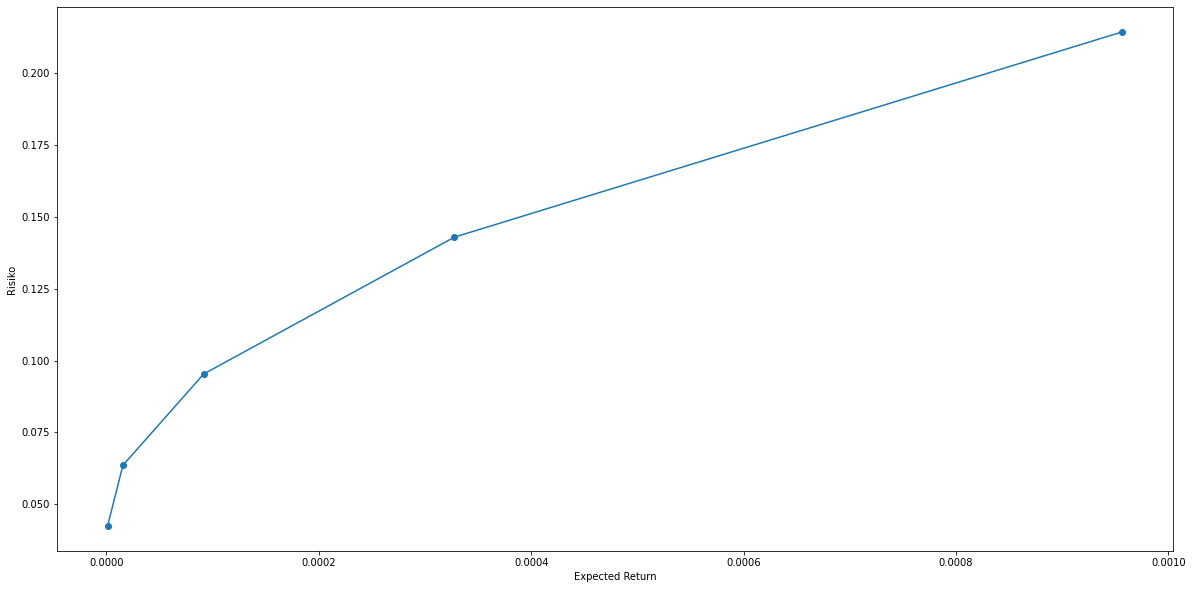

In [251]:
import matplotlib.pyplot as plt

y = new_df["Expected Return"]
x = new_df["Risiko"]

plt.figure(figsize=(20,10))
plt.plot(x,y)
plt.scatter(x,y)
plt.xlabel("Expected Return")
plt.ylabel("Risiko")
plt.show()

# No 3a

## Load Data

In [221]:
dataset_2019 = load_data(2019,kode_saham)
dataset_2019


,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK
0,2350.0,3770.0,6050.0,2290.0,700.0
1,2420.0,3850.0,6725.0,2170.0,730.0
2,2350.0,4030.0,7400.0,2170.0,735.0
3,2320.0,3780.0,7000.0,2420.0,720.0
4,2250.0,3780.0,7050.0,2850.0,720.0
5,2340.0,3930.0,7025.0,2900.0,720.0
6,2300.0,3900.0,6550.0,2940.0,755.0
7,2260.0,3910.0,6550.0,2950.0,680.0
8,2280.0,3850.0,6500.0,2900.0,645.0
9,2450.0,3800.0,6400.0,2810.0,590.0


In [222]:
K_2019 = return_saham(dataset_2019)
K_2019

,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK
0,0.067327,0.063704,0.069513,0.086151,0.064925


In [223]:
var = function_var(dataset_2019).iloc[0,:].values
function_var(dataset_2019)

,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK
0,0.000048,0.000002,0.0005,0.000155,0.000577


In [224]:
std_dev = function_std_dev(var)
print(function_std_dev(var))

[0.006906167791449115, 0.0013003519157969102, 0.022352728966575766, 0.012434773815419308, 0.02401685518158682]


In [225]:
rho = dataset_2019.corr().values
dataset.corr()

,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK
SGRO.JK,1.000000,-0.336531,0.282667,-0.599204,-0.559313
TLKM.JK,-0.336531,1.000000,-0.647548,0.348964,0.244041
INDR.JK,0.282667,-0.647548,1.000000,-0.715454,-0.019710
PRDA.JK,-0.599204,0.348964,-0.715454,1.000000,0.189698
AKPI.JK,-0.559313,0.244041,-0.019710,0.189698,1.000000


In [0]:
C = Matrix_C()

In [227]:
def Expected_Return(df_K,df_saham) :
  return_saham = []
  n = df_saham.shape[0]

  for i in range(n):
    sum_ret = 0
    for saham in df_saham :
      K = float(df_K[saham])
      w = float(df_saham[saham][i])
      sum_ret += K*w
    return_saham.append(sum_ret)
  result = pd.DataFrame([return_saham])
  result.columns = ["ER"+str(x+1) for x in range(n)]
  return result

Expected_Return(K_2019,new_df.iloc[:2,:n])

,ER1,ER2
0,0.068031,0.068256


In [228]:
list_bobot = []
i = 0
print(kode_saham)

w_use = new_df.iloc[:2,:n]

ER = Expected_Return(K_2019,w_use)

for bobot in w_use.values :
  #print(bobot)
  tmp = []
  wT = np.transpose(bobot)
  risk = bobot.dot(C).dot(wT)
  for x in bobot :
    tmp.append(x)
  tmp.append(ER.iloc[0,i])
  tmp.append(risk)
  list_bobot.append(tmp)
  i+=1
print(list_bobot)

new_df_port = pd.DataFrame(list_bobot)
new_df_port.columns = column
new_df_port
#df_tmp =df_port
new_df_port

['SGRO.JK', 'TLKM.JK', 'INDR.JK', 'PRDA.JK', 'AKPI.JK']
[[0.4368, 0.3916, 0.0592, 0.1063, 0.0062, 0.06803052788203699, 1.1210526430245724e-06], [-0.4405408962812911, 1.0103516837733697, 0.25450042263910677, 0.2099116347242398, -0.03422284485539286, 0.06825633685598663, 1.5590775207607807e-05]]


,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK,Expected Return,Risiko
0,0.436800,0.391600,0.0592,0.106300,0.006200,0.068031,0.000001
1,-0.440541,1.010352,0.2545,0.209912,-0.034223,0.068256,0.000016


In [229]:
new_df.iloc[:2,:]

,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK,Expected Return,Risiko
0,0.436800,0.391600,0.0592,0.106300,0.006200,0.042353,0.000001
1,-0.440541,1.010352,0.2545,0.209912,-0.034223,0.063530,0.000016


## No 3b

In [231]:
kode_saham = kode_saham[:n]
print(kode_saham)
dataset_2020 = load_data("2019",kode_saham)
dataset_2020.sample(5)

['SGRO.JK', 'TLKM.JK', 'INDR.JK', 'PRDA.JK', 'AKPI.JK']


,SGRO.JK,TLKM.JK,INDR.JK,PRDA.JK,AKPI.JK
24,2260.0,3980.0,4950.0,3670.0,440.0
14,2300.0,3830.0,4660.0,2860.0,600.0
0,2350.0,3770.0,6050.0,2290.0,700.0
17,2360.0,3840.0,4840.0,3310.0,570.0
49,2380.0,3950.0,2730.0,3630.0,394.0


In [232]:
VP = {}
V0 = 1
n_port = w_use.shape[0]
for i in range(n_port):
  VP[i] = [V0]

print(n_port)

for i in range(n_port):
  for j in range(dataset_2020.shape[0]-1):
    v = 0
    for saham in dataset_2020 :
      Sn = dataset_2020[saham][j+1]
      Sm = dataset_2020[saham][j]

      K = (Sn-Sm)/Sm

      w = w_use[saham][i]
      V += K*w
    VP[i].append((1+V0)*V)

print(VP)

df_sim = pd.DataFrame(VP)
df_sim.columns = ["P"+str(i+1) for i in range(n_port)]
df_sim


2
{0: [1, 1.4739058020318834, 1.4972224697781609, 1.4553245477452963, 1.4675876743992067, 1.5369210058839469, 1.5115385442171183, 1.4978450470392932, 1.4884121642498507, 1.5339007439465788, 1.5445212567261302, 1.5064825323944, 1.542451828486913, 1.4944395034434441, 1.4565751010151746, 1.4550763823735262, 1.4826154466600368, 1.5187583158602387, 1.4875071673829492, 1.4593226097033838, 1.5234632990542458, 1.5219191550880222, 1.5063296121863932, 1.5049133472852152, 1.5375786517106942, 1.6003702396716235, 1.6551591261637735, 1.596864325775245, 1.6127203470315992, 1.5843422603796717, 1.5684344338698801, 1.629287154181349, 1.6434140254487302, 1.6538195877761128, 1.6215117074405045, 1.637639576548289, 1.6018043652668204, 1.5851458782035857, 1.5839163643659453, 1.569674383177891, 1.5349605053897921, 1.6058375617769052, 1.6339214240857882, 1.6117530033733396, 1.633282385336645, 1.623345121404174, 1.589597665387774, 1.5670757289361676, 1.6039549610408343, 1.5367785604529873], 1: [1, 1.58526970911

,P1,P2
0,1.000000,1.000000
1,1.473906,1.585270
2,1.497222,1.755850
3,1.455325,1.663995
4,1.467588,1.768811
5,1.536921,1.819315
6,1.511539,1.786998
7,1.497845,1.815730
8,1.488412,1.769446
9,1.533901,1.662485


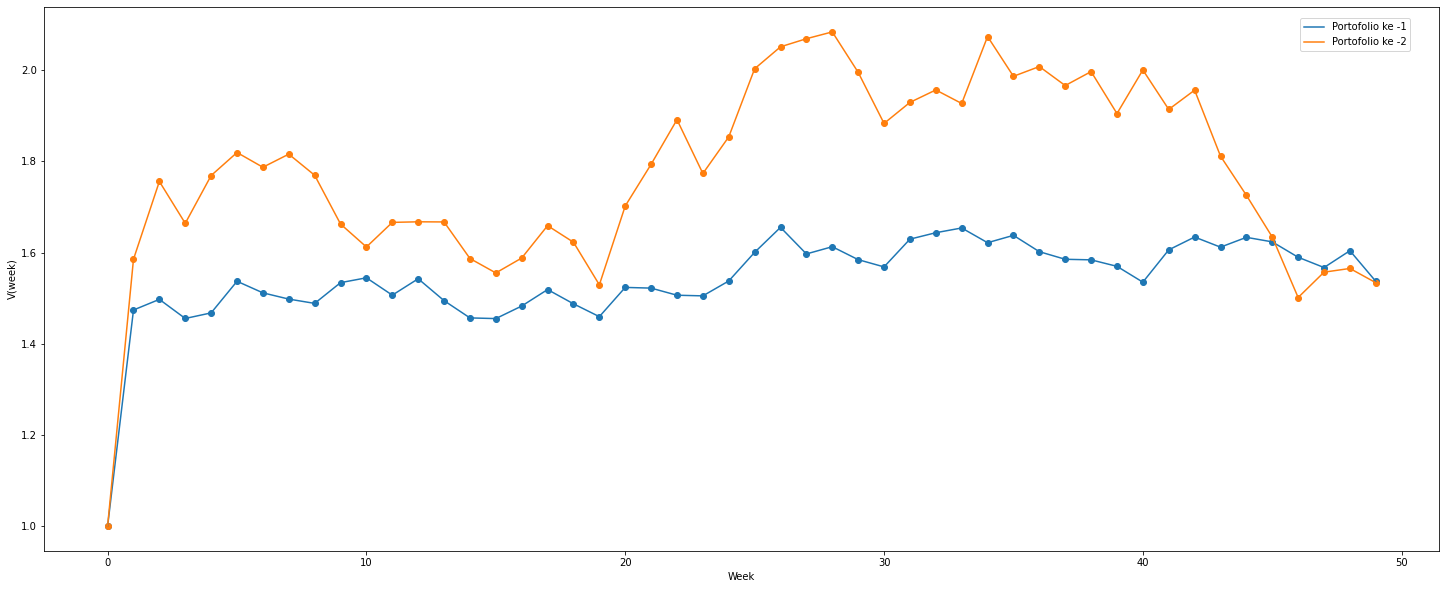

In [252]:
import matplotlib.pyplot as plt


plot_list = []
plt.figure(figsize=(25,10))
for i in range(n_port):
  x = [x for x in range(df_sim.shape[0])]
  y = df_sim["P"+str(i+1)]
  plt.plot(x,y,label="Portofolio ke -"+str(i+1))
  plt.scatter(x,y)

plt.legend(bbox_to_anchor=(0.9, 0.98), loc='upper left', borderaxespad=0.)
plt.xlabel("Week")
plt.ylabel("V(week)")
plt.show()

## Salah


In [0]:
"""import numpy as np
#print(type(dataset.corr()))
list_corr = []
for x in dataset:
  print(type(dataset.corr()[x]))
  #print(dataset[x].corr())
  #list_corr.append(dataset[x].corr().tolist())
  #print(dataset.corr()[x].tolist())
#rho = np.array(list_corr)
#print(rho)"""

'import numpy as np\n#print(type(dataset.corr()))\nlist_corr = []\nfor x in dataset:\n  print(type(dataset.corr()[x]))\n  #print(dataset[x].corr())\n  #list_corr.append(dataset[x].corr().tolist())\n  #print(dataset.corr()[x].tolist())\n#rho = np.array(list_corr)\n#print(rho)'

In [0]:
"""import statistics as st
var = []
for x in kode_saham :
  tmp = dataset[x].tolist()
  #print(tmp)
  var.append(st.variance(tmp))
#print(var)
df_var = pd.DataFrame([var])
df_var.columns = kode_saham
df_var"""

'import statistics as st\nvar = []\nfor x in kode_saham :\n  tmp = dataset[x].tolist()\n  #print(tmp)\n  var.append(st.variance(tmp))\n#print(var)\ndf_var = pd.DataFrame([var])\ndf_var.columns = kode_saham\ndf_var'

In [0]:
def convert_to_dollar(saham) :
  usd = 15589
  dollar = []
  for x in saham :
    dollar.append(x/usd)
  return dollar


In [0]:


def is_short_selling(rho,std_dev):
  n = len(rho)
  print(n)
  check = False
  #rho = rho.sort()
  #std_Dev =std_dev.sort()
  sahamnya = []
  for i in range(n):
    for j in range(n):
      if i < j :
        x = std_dev[i]/std_dev[j]
        #print(rho[i][j])
        if rho[i][j] > x :
          check =True
          sahamnya.append([kode_saham[i],kode_saham[j]])
    
  return [check,sahamnya]

if(is_short_selling(rho,std_dev)[0]) :
  short = {}
  list_short = is_short_selling(rho,std_dev)[1]
  print(list_short)
  for i in list_short :
    x = i[0]
    y = i[1]
    if x not in short.keys():
      short[x] =1
    else :
      short[x] += 1
    
    if y not in short.keys():
      short[y] = 1
    else :
      short[y] += 1
  print(short)
else :
  print("aman")
  print(kode_saham)

5
5
[['SGRO.JK', 'INDR.JK'], ['TLKM.JK', 'PRDA.JK'], ['TLKM.JK', 'AKPI.JK']]
{'SGRO.JK': 1, 'INDR.JK': 1, 'TLKM.JK': 2, 'PRDA.JK': 1, 'AKPI.JK': 1}
